<a href="https://colab.research.google.com/drive/1EyiPf09NyR8LrAxkHTHpXLQ7fNj59wdp?usp=sharing" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
import json
import matplotlib.pyplot as plt
import math
#dossier asset.zip (extract_data.py,vizualization.py, dataa.json,datasetA.json (de son choix))
#dossier Transformer.zip
#mode exec GPU

In [2]:
!unzip assets.zip

Archive:  assets.zip
  inflating: assets/data.json        
  inflating: assets/dataset.json     
  inflating: assets/datasetA.json    
  inflating: assets/extract_data.py  
  inflating: assets/visualization.py  


In [3]:
!unzip Transformer.zip

Archive:  Transformer.zip
   creating: Transformer/.ipynb_checkpoints/
  inflating: Transformer/.ipynb_checkpoints/melodygenerator-checkpoint.py  
  inflating: Transformer/.ipynb_checkpoints/melodypreprocessor-checkpoint.py  
  inflating: Transformer/.ipynb_checkpoints/transformer-checkpoint.py  
 extracting: Transformer/__init__.py  
   creating: Transformer/__pycache__/
  inflating: Transformer/__pycache__/__init__.cpython-311.pyc  
  inflating: Transformer/__pycache__/__init__.cpython-37.pyc  
  inflating: Transformer/__pycache__/melodygenerator.cpython-311.pyc  
  inflating: Transformer/__pycache__/melodygenerator.cpython-37.pyc  
  inflating: Transformer/__pycache__/melodypreprocessor.cpython-37.pyc  
  inflating: Transformer/__pycache__/train.cpython-37.pyc  
  inflating: Transformer/__pycache__/transformer.cpython-37.pyc  
  inflating: Transformer/melodygenerator.py  
  inflating: Transformer/melodypreprocessor.py  
  inflating: Transformer/train.py    
  inflating: Transformer/

In [4]:
sys.path.append('/content/Transformer')
sys.path.append('/content/assets')

In [5]:
from melodygenerator import *
from melodypreprocessor import *
from train import *
from transformer import *
from train import _train_step


tf.config.list_physical_devices('GPU')

[]

In [6]:
from extract_data import *
from visualization import n_measure

In [7]:
melody_preprocessor = MelodyPreprocessor("assets/datasetA.json", batch_size=32)
train_dataset = melody_preprocessor.create_training_dataset()
vocab_size = melody_preprocessor.number_of_tokens_with_padding
transformer_model = Transformer(
    num_layers=2,
    d_model=64,
    num_heads=2,
    d_feedforward=128,
    input_vocab_size=vocab_size,
    target_vocab_size=vocab_size,
    max_num_positions_in_pe_encoder=384,
    max_num_positions_in_pe_decoder=384,
    dropout_rate=0.2,
)

with tf.device('/device:GPU:0'):
    iters,losses=train(train_dataset, transformer_model,5)



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Epoch 1 Batch 981 Loss 1.3828508853912354
Epoch 1 Batch 982 Loss 1.169061303138733
Epoch 1 Batch 983 Loss 1.5218836069107056
Epoch 1 Batch 984 Loss 1.1991273164749146
Epoch 1 Batch 985 Loss 1.4726651906967163
Epoch 1 Batch 986 Loss 1.163615107536316
Epoch 1 Batch 987 Loss 1.3776267766952515
Epoch 1 Batch 988 Loss 1.1128753423690796
Epoch 1 Batch 989 Loss 1.381218671798706
Epoch 1 Batch 990 Loss 1.2405624389648438
Epoch 1 Batch 991 Loss 1.1779811382293701
Epoch 1 Batch 992 Loss 1.4170200824737549
Epoch 1 Batch 993 Loss 1.4830418825149536
Epoch 1 Batch 994 Loss 1.3929731845855713
Epoch 1 Batch 995 Loss 1.0213743448257446
Epoch 1 Batch 996 Loss 1.4114261865615845
Epoch 1 Batch 997 Loss 1.6165742874145508
Epoch 1 Batch 998 Loss 1.7201582193374634
Epoch 1 Batch 999 Loss 1.363824486732483
Epoch 1 Batch 1000 Loss 1.5454730987548828
Epoch 1 Batch 1001 Loss 1.996281385421753
Epoch 1 Batch 1002 Loss 1.0810344219207764


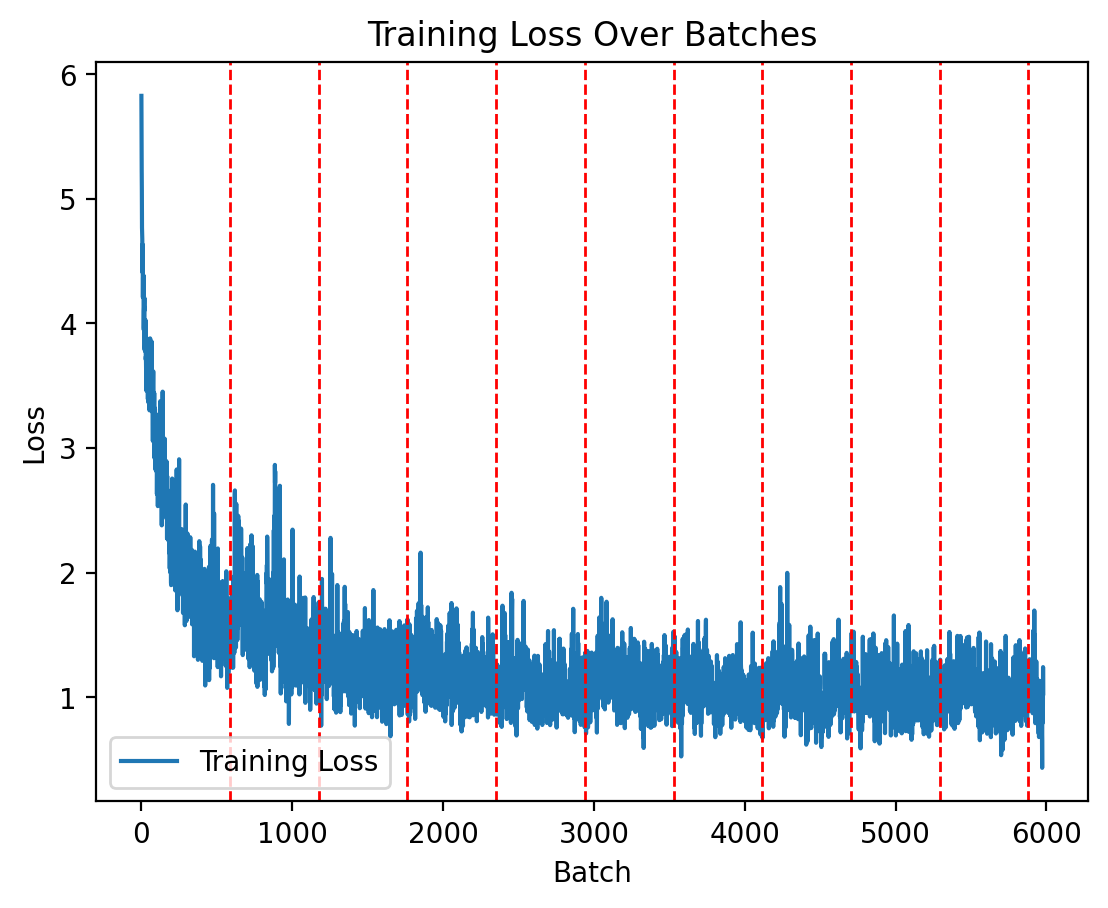

In [8]:
def plot_losses(iters,losses,batchs):
    plt.plot(iters,losses, label='Training Loss')
    for i in range(batchs,len(iters),batchs):
        plt.axvline(x=i, color='r', linestyle='--', linewidth=1)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Batches')
    plt.legend()
    plt.show()

plot_losses(iters,losses,1195)

In [13]:
melody_generator = MelodyGenerator(
    transformer_model, melody_preprocessor.tokenizer,30
)

In [27]:
def generate_seq(original,lg_debut,lg_predict):
    original_size= len(original)
    print(f'Nombre de mesures dans l\'original : {original_size}')
    size=lg_debut+lg_predict
    debuts=[]
    fins=[]
    for i in range(size,original_size+1):
        seq_debut= [ n for  m in original[i-size:i-lg_predict] for n in m]
        seq_originale= [ n for  m in original[i-size:i] for n in m if i<original_size]
        debuts.append(seq_debut)
        fins.append(seq_originale)
    return debuts,fins,original_size

def generate_decalage(original,lg_debut,lg_predict,mode=2,k=40,first_proba=0.8,time_signature="2/4"):
    '''Genere une partie A
      Parametres:
            original (liste de string) : Partie originale
            lg_debut (int) : Longueur sequence de départ en mesure
            lg_fin (int) : Longueur sequence prédite en mesure
            ***param du melody_generator.generate()
    '''
    melodie=[]
    debuts,fins,original_size=generate_seq(original,lg_debut,lg_predict)
    melodie.append(debuts[0])
    probas= [[ 1 for m in debuts[0] for _ in m ]]
    size=lg_debut+lg_predict
    for i in range(len(debuts)):
      new_melodie,p=melody_generator.generate(debuts[i],mode=mode,k=k)
      new_melodie=new_melodie.split(' ')[len(debuts[i]):]
      new_melodie=n_measure(new_melodie,lg_predict,time_signature)
      melodie.append(new_melodie)
      p= p[len(debuts[i]):len(debuts[i])+len(new_melodie)]
      #print(new_melodie)
      probas.append(p)
      print(f'Mesure {size+i} : generated')
    melodie = [ n for measure in melodie for n in measure ]
    print("Melodie generated")
    return melodie,probas






In [36]:
melodies_generated=[]

In [37]:
error_part_A= ['Sarau para Radamés','DESPREZADO','ACARICIANDO']

for _ in range(10):
  print("Generating a melody...")
  seq=extract_random_seq("assets/data.json",1,"A")
  print(seq[0])
  original= extract_seq_from("assets/data.json",seq[0],seq[2],mode="mesure")[-1]
  while seq[1]!= "2/4" or seq[0] in error_part_A:
      seq=extract_random_seq("assets/data.json",1,"A")
      original= extract_seq_from("assets/data.json",seq[0],seq[2],mode="mesure")[-1]
  new_melody,p = generate_decalage(original,2,1,mode=2,k=10,first_proba=0.6)
  original=[ n for m in original for n in m]
  melodies_generated.append((seq,new_melody,original,p))

  print(new_melody)
  print(original)
  print(p)
  print('--')



Generating a melody...
A
NENÊ
Nombre de mesures dans l'original : 16
Mesure 3 : generated
Mesure 4 : generated
Mesure 5 : generated
Mesure 6 : generated
Mesure 7 : generated
Mesure 8 : generated
Mesure 9 : generated
Mesure 10 : generated
Mesure 11 : generated
Mesure 12 : generated
Mesure 13 : generated
Mesure 14 : generated
Mesure 15 : generated
Mesure 16 : generated
Melodie generated
['B4-0.5', 'A4-0.25', 'rest-0.5', 'F#5-0.5', 'E5-0.5', 'D5-0.25', 'rest-0.25', 'C#5-0.25', 'B4-0.25', 'D5-0.25', 'rest-0.5', 'rest-0.5', 'rest-0.25', 'A5-0.5', 'rest-0.25', 'D5-0.25', 'rest-0.25', 'D5-0.25', 'rest-0.25', 'D5-0.25', 'rest-0.25', 'D5-0.25', 'rest-0.25', 'B4-0.25', 'A4-0.5', 'B4-0.25', 'A4-0.5', 'B4-0.25', 'A4-0.25', 'G#4-0.25', 'B4-0.5', 'G#4-0.25', 'B4-0.5', 'G#4-0.25', 'B4-0.25', 'D5-0.25', 'rest-0.5', 'rest-0.25', 'rest-0.5', 'D5-0.25', 'G5-0.25', 'D5-0.5', 'rest-0.25', 'D-5-0.25', 'rest-0.25', 'D-5-0.25', 'rest-0.25', 'D-5-0.25', 'B4-0.25', 'C#5-0.25', 'B4-0.25', 'C#5-0.25', 'D5-0.25', 

In [ ]:
#original= extract_seq_from2("assets/data.json",'Sarau para Radamés','A')
#print(original)

In [38]:
generated = [ {'Title' : s[0] , "Time_signarue" : s[1], 'Part': s[2], 'Key' : s[3] ,'Generated' : m , 'Original' : o , 'Proba' : [ str(prob) for proba in p for prob in proba] } for (s,m,o,p) in melodies_generated ]
print(len(generated))

10


In [39]:
with open("generated.json","w") as f:
    json.dump(generated,f,indent=2)